### TSMC2330 Stock Price Estimate

In [11]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ta import add_all_ta_features
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### 讀取資料

In [12]:
# 🔹 讀取資料
df = pd.read_csv("tsmc2330-1.csv")
#df["Date"] = pd.to_datetime(df["Date"])
#df = df.sort_values("Date")

# 🔍 查看資料結構
df.head()

,Column1,Date,Open,High,Low,Close,Volume,Return,MA5,MA10,MA20,Price_Change,RSI,MACD,MACD_Signal,BB_Upper,BB_Lower,Target
0,19,2020/2/7,298.235036,298.686908,294.620066,296.427551,28798327,-1.35,294.258600,295.071942,299.997342,-1.807485,43.065737,-1.508643,-1.431600,315.071159,284.923525,0
1,20,2020/2/10,290.553192,296.427518,290.101321,295.975647,30632424,-0.15,296.517938,294.439319,299.477689,5.422455,41.044731,-1.420512,-1.429362,314.341801,284.613577,0
2,21,2020/2/11,298.686925,300.494410,298.235054,299.590668,27524935,1.22,297.692786,294.303763,299.116191,0.903743,42.753644,-1.092871,-1.361563,313.574510,284.657872,1
3,22,2020/2/12,301.398109,303.657466,300.946238,302.753723,37612639,1.06,299.048401,294.484512,299.251747,1.355614,41.911724,-0.610923,-1.210544,313.797212,284.706282,1
4,23,2020/2/13,305.464950,305.464950,302.753723,302.753723,22757021,0.00,299.500262,296.156436,299.500276,-2.711227,45.967695,-0.229394,-1.013383,314.109803,284.890749,0


In [ ]:
#features = df.drop(columns=["Column1", "Date", "Target"])
features = df
X = features
y = df["Target"]

In [15]:
df.describe()

,Column1,Open,High,Low,Close,Volume,Return,MA5,MA10,MA20,Price_Change,RSI,MACD,MACD_Signal,BB_Upper,BB_Lower,Target
count,1293.000000,1293.000000,1293.000000,1293.000000,1293.000000,1.293000e+03,1293.000000,1293.000000,1293.000000,1293.000000,1293.000000,1293.000000,1293.000000,1293.000000,1293.000000,1293.000000,1293.000000
mean,665.000000,598.167320,602.647212,593.261381,597.876211,3.641501e+07,0.106783,596.858889,595.549026,592.932956,-0.291110,53.450762,3.513029,3.462868,629.242960,556.622952,0.486466
std,373.401259,217.742813,219.816798,215.905381,217.747986,2.090993e+07,1.889767,217.346931,216.885792,215.823235,7.146125,16.732702,12.822760,12.064012,230.781290,202.556379,0.500010
min,19.000000,229.954220,230.866737,214.897694,226.304153,0.000000e+00,-9.980000,236.510290,242.813681,248.650068,-36.828350,6.666781,-47.834610,-39.928779,267.123004,218.755947,0.000000
25%,342.000000,473.941292,477.633272,470.278165,473.531006,2.250151e+07,-0.930000,472.985791,472.269153,466.826527,-3.801458,41.176509,-3.138499,-2.971861,501.030155,439.658069,0.000000
50%,665.000000,548.727081,552.878174,544.558777,549.277466,3.194178e+07,0.000000,549.310620,549.785785,550.406886,0.000000,52.678749,2.618550,2.650522,573.259220,522.198066,0.000000
75%,988.000000,625.707287,631.064884,619.420765,625.488464,4.323142e+07,1.100000,627.483765,620.366565,612.186508,2.899694,65.531915,10.304376,10.113208,648.611317,577.230496,1.000000
max,1311.000000,1144.664906,1154.618514,1129.734497,1129.734497,1.663077e+08,9.970000,1114.804077,1106.343506,1100.869019,41.000000,100.000000,44.296141,39.996126,1141.822776,1062.035825,1.000000


### 上面的變數 features 存放各個特徵變數的資料。除了 "Column1","Date","Target" 3個欄位外，其餘欄位請做 RobustScalor 標準化並寫入 tsmc2330-2_Robust.csv，"Column1","Date","Target"三欄原始資料請一併寫入至原來的欄位位置。

In [16]:
from sklearn.preprocessing import RobustScaler

# 需要標準化的欄位
feature_cols = [col for col in df.columns if col not in ["Column1", "Date", "Target"]]

# RobustScaler 標準化
scaler = RobustScaler()
df_scaled = df.copy()
df_scaled[feature_cols] = scaler.fit_transform(df[feature_cols])

# 寫入 CSV
df_scaled.to_csv("tsmc2330-2_Robust.csv", index=False)

# prompt: 請使用 Prof. J.W.Tukey 在1977年於Exploratory data analysis 所發表的方式計算 tsmc2330-2_Robust.csv 各欄的盒鬚圖及長條圖的常態分佈圖、Q-Q plot. ("Column1", "Date", "Target" 3欄不用畫圖)

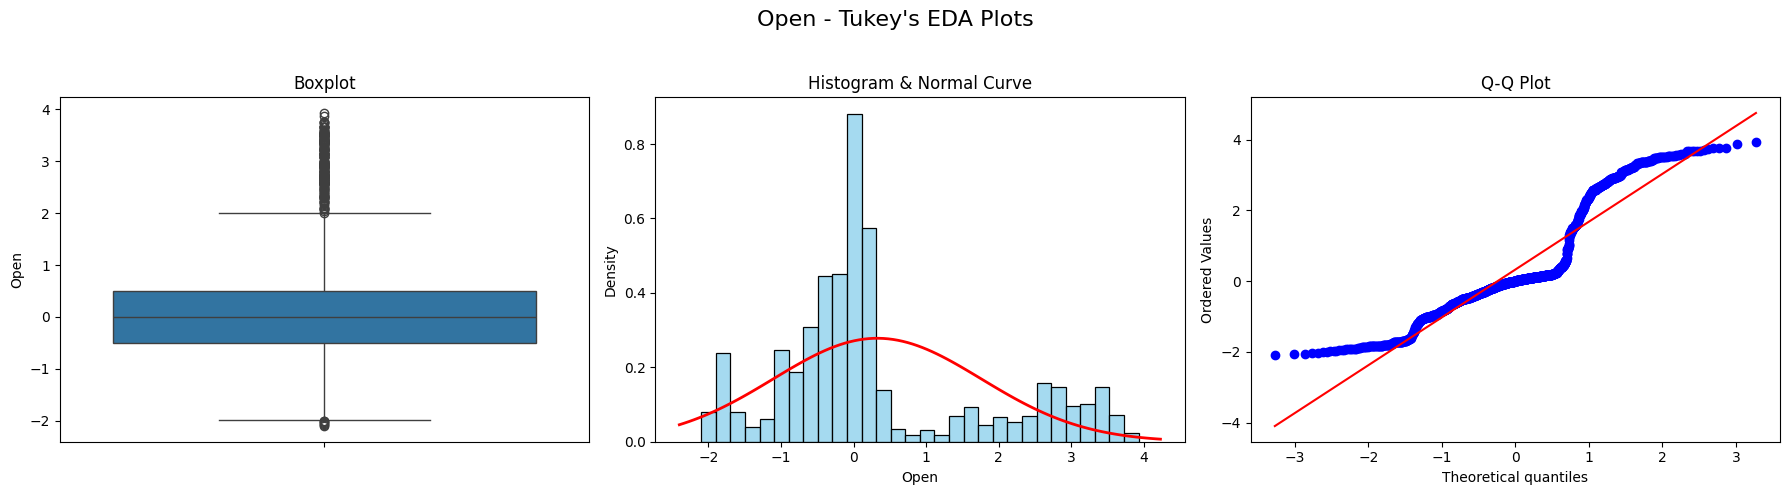

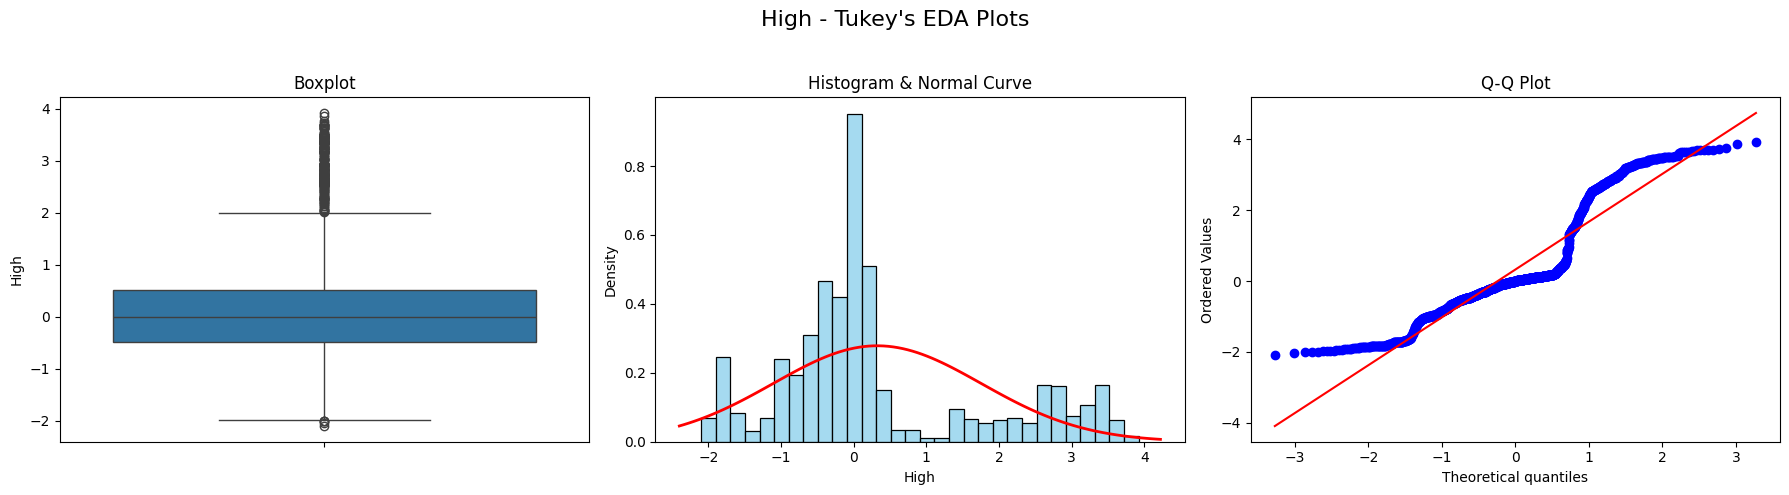

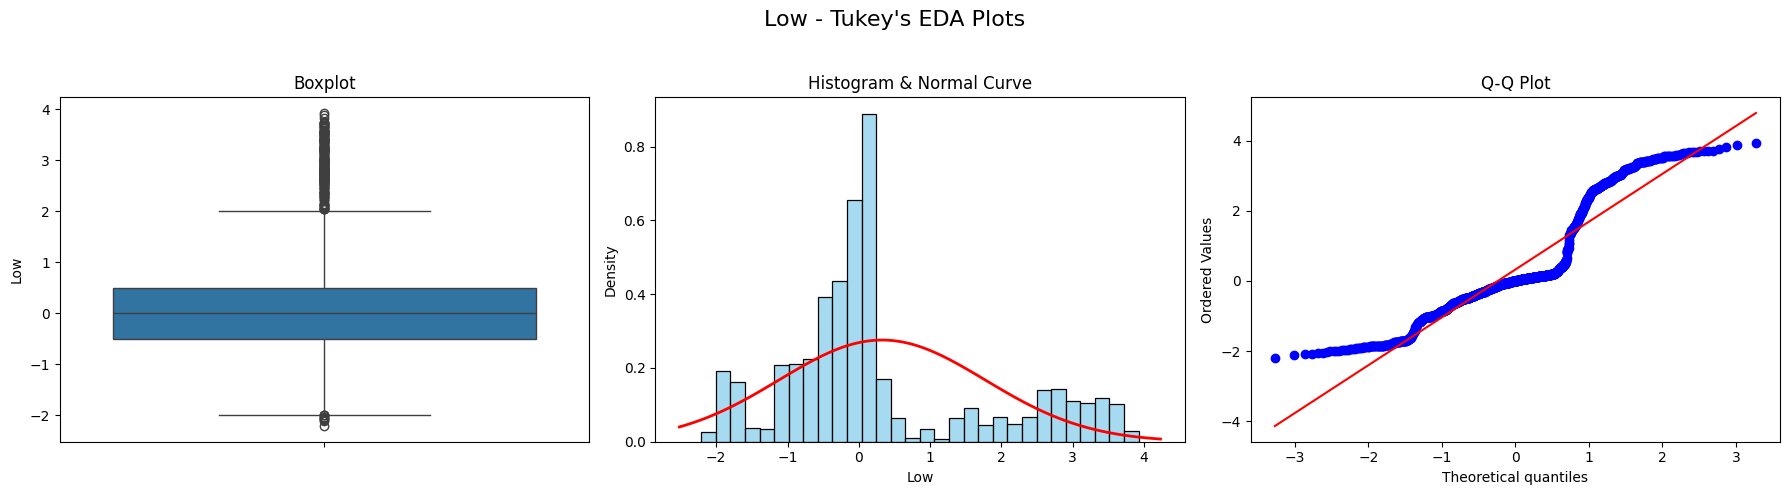

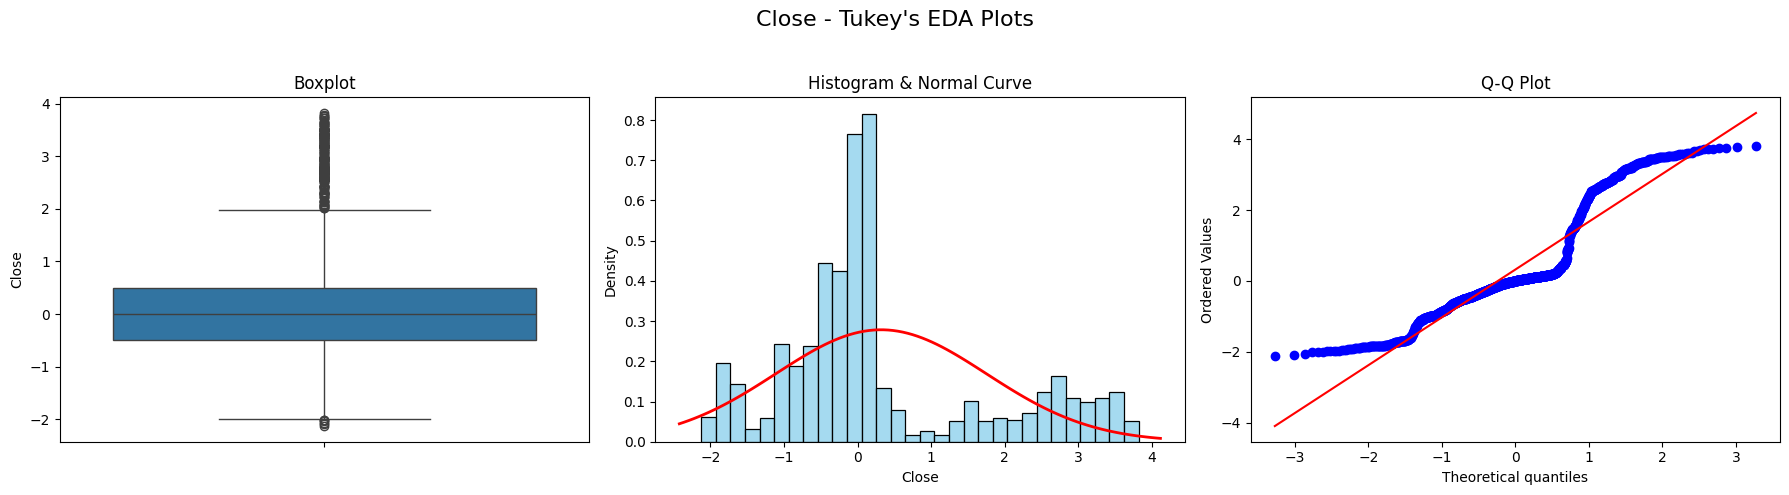

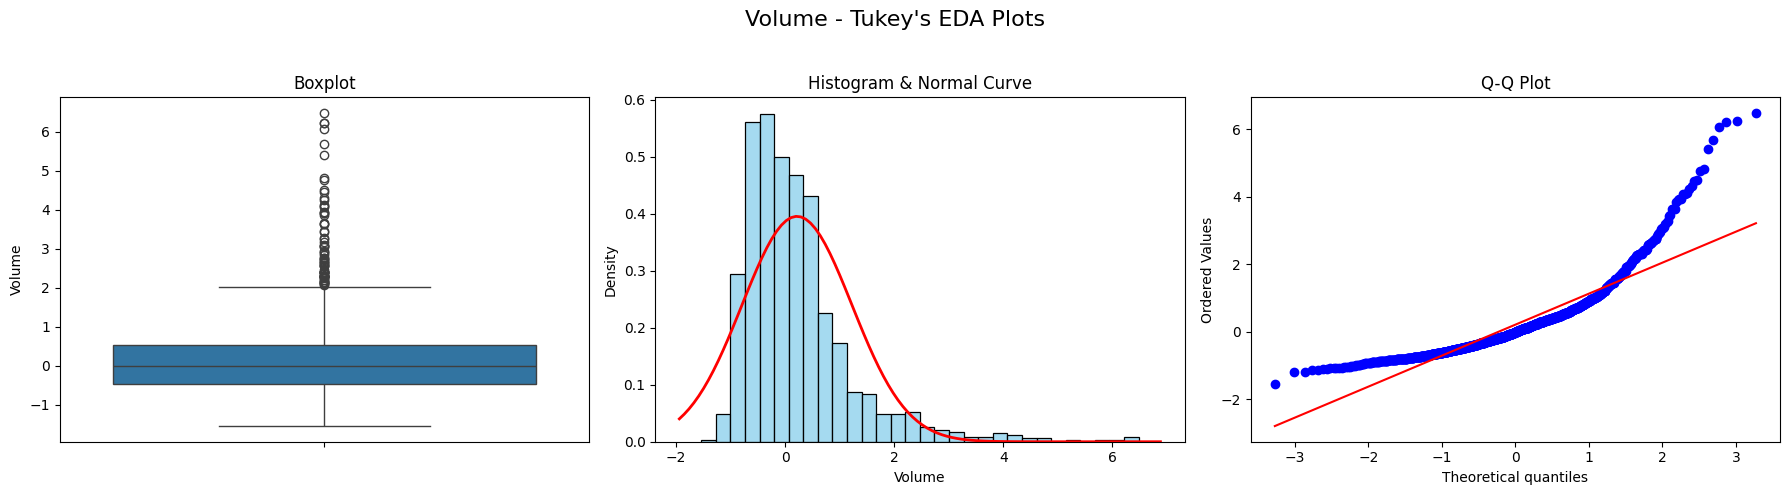

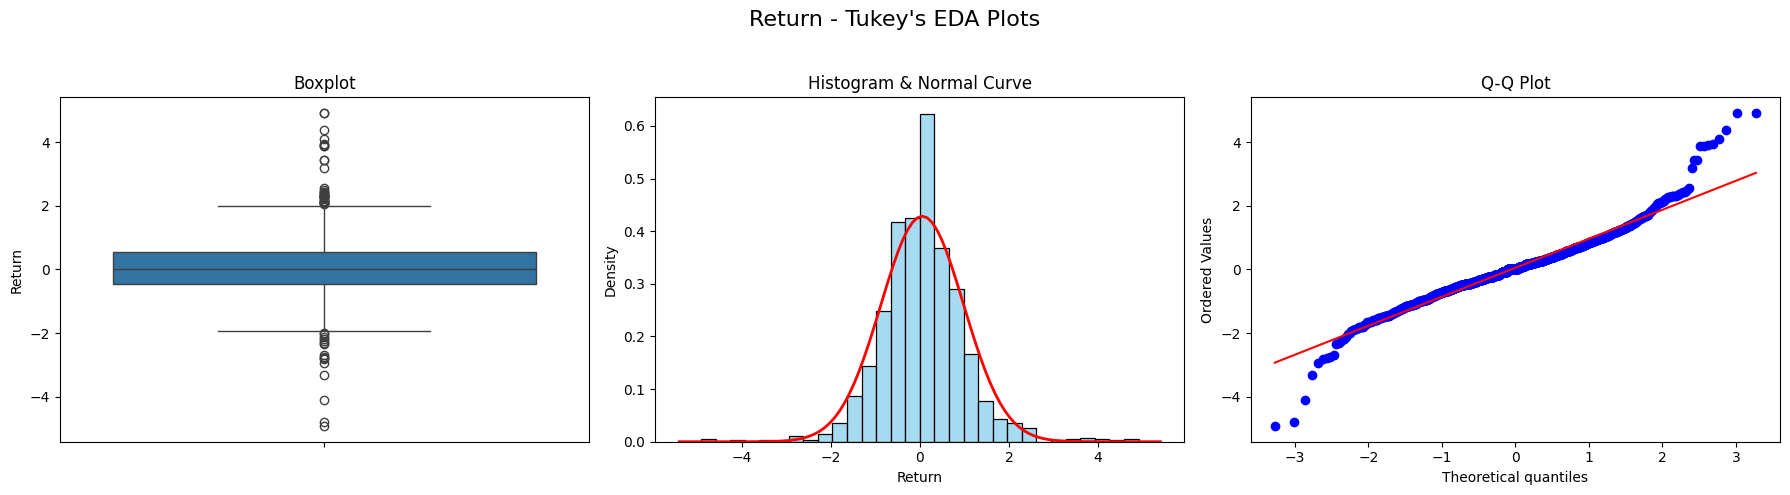

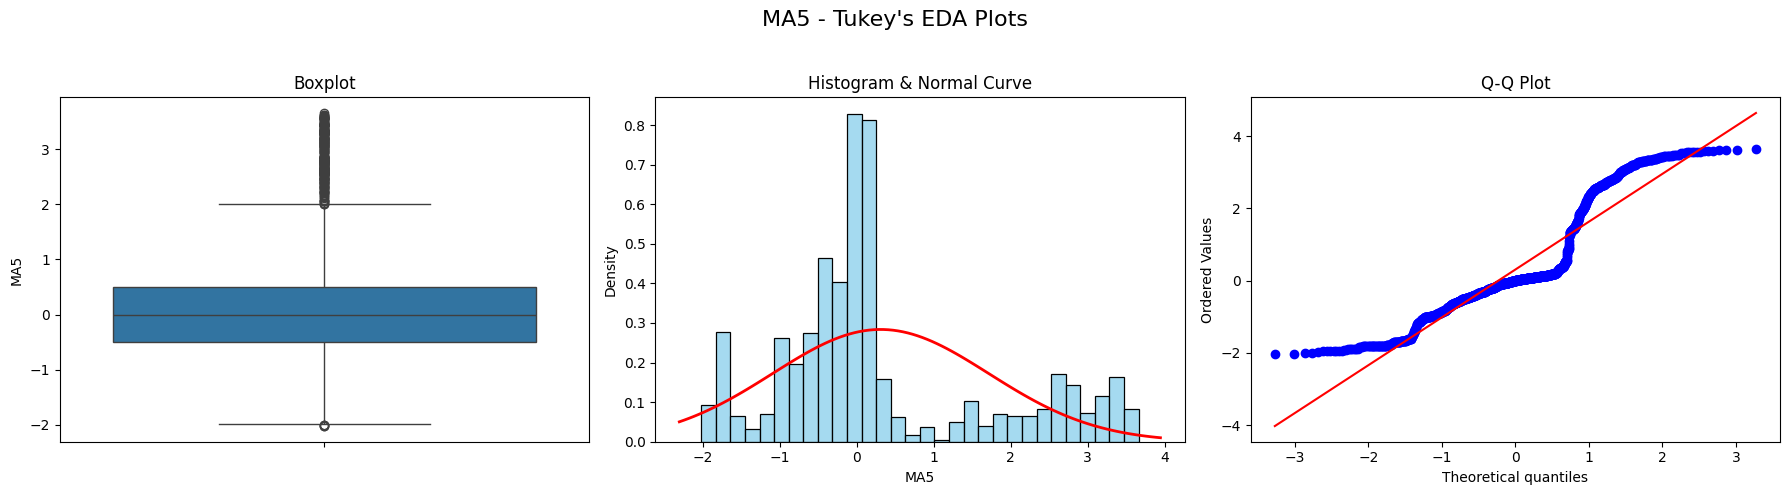

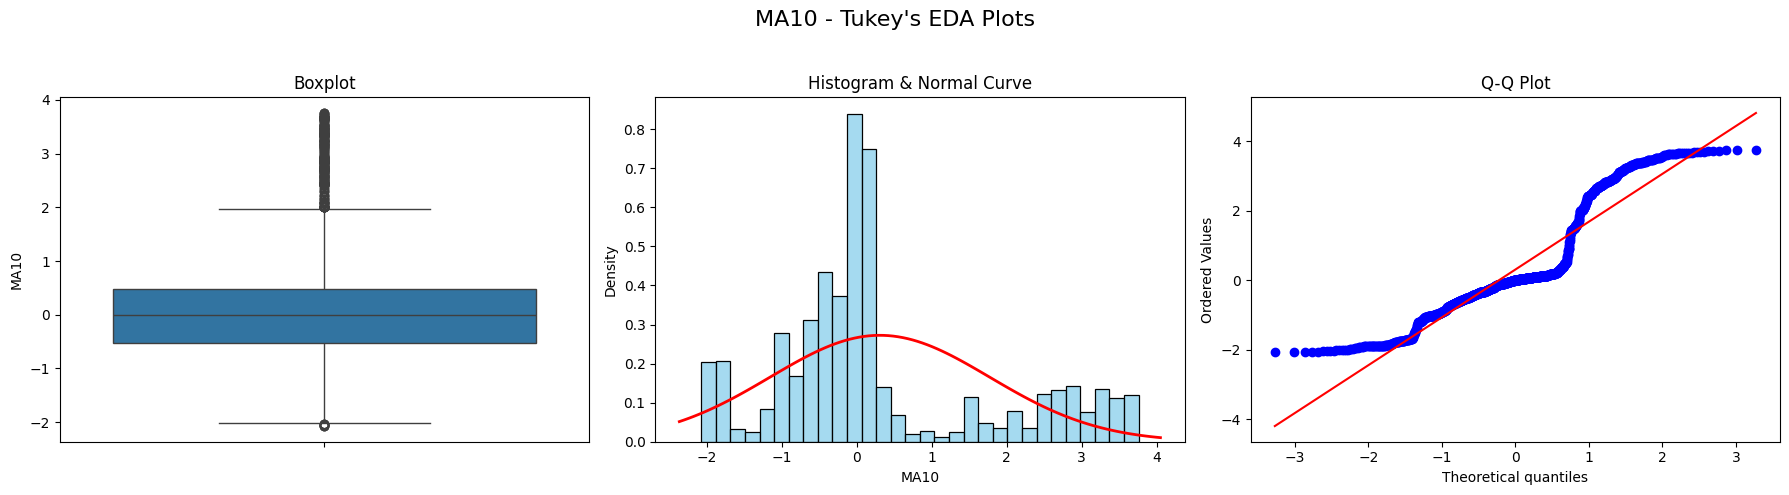

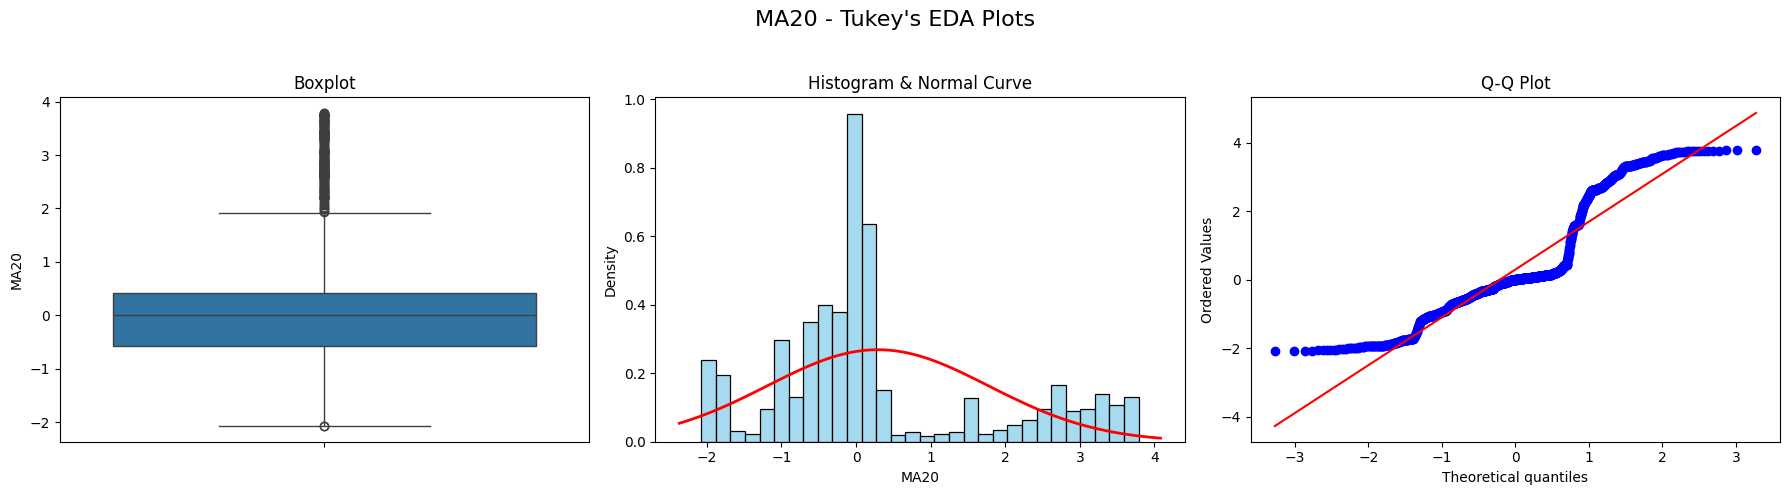

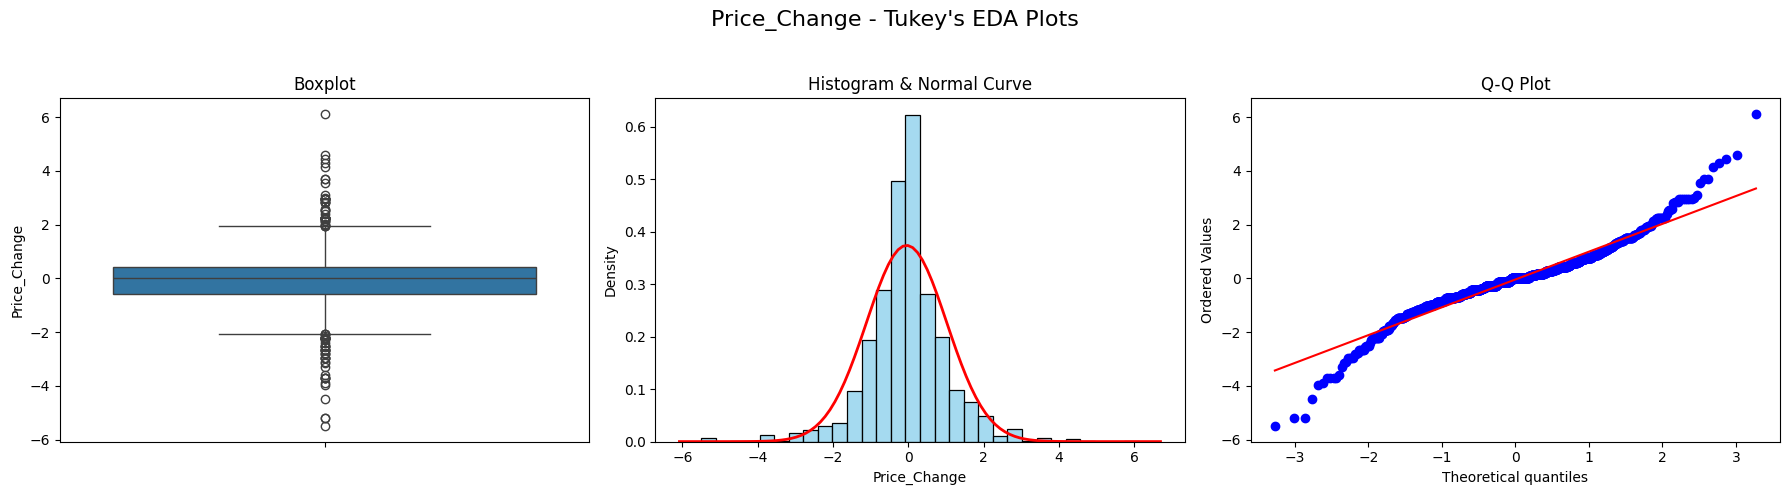

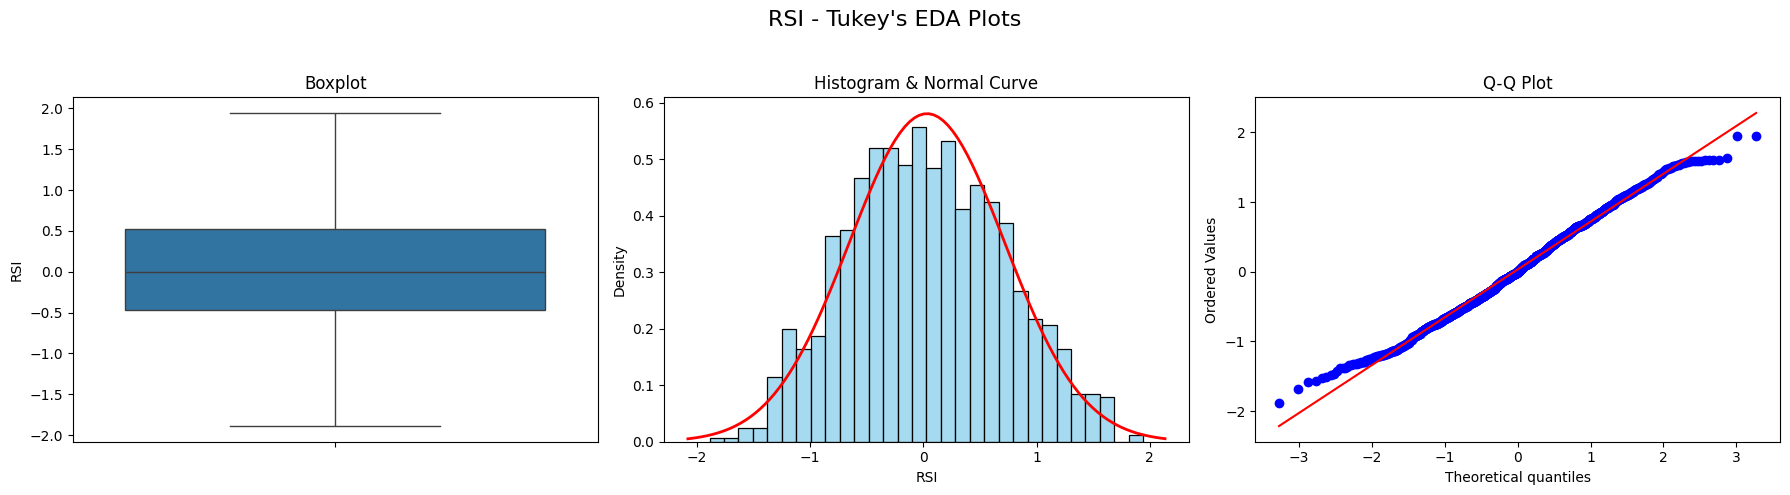

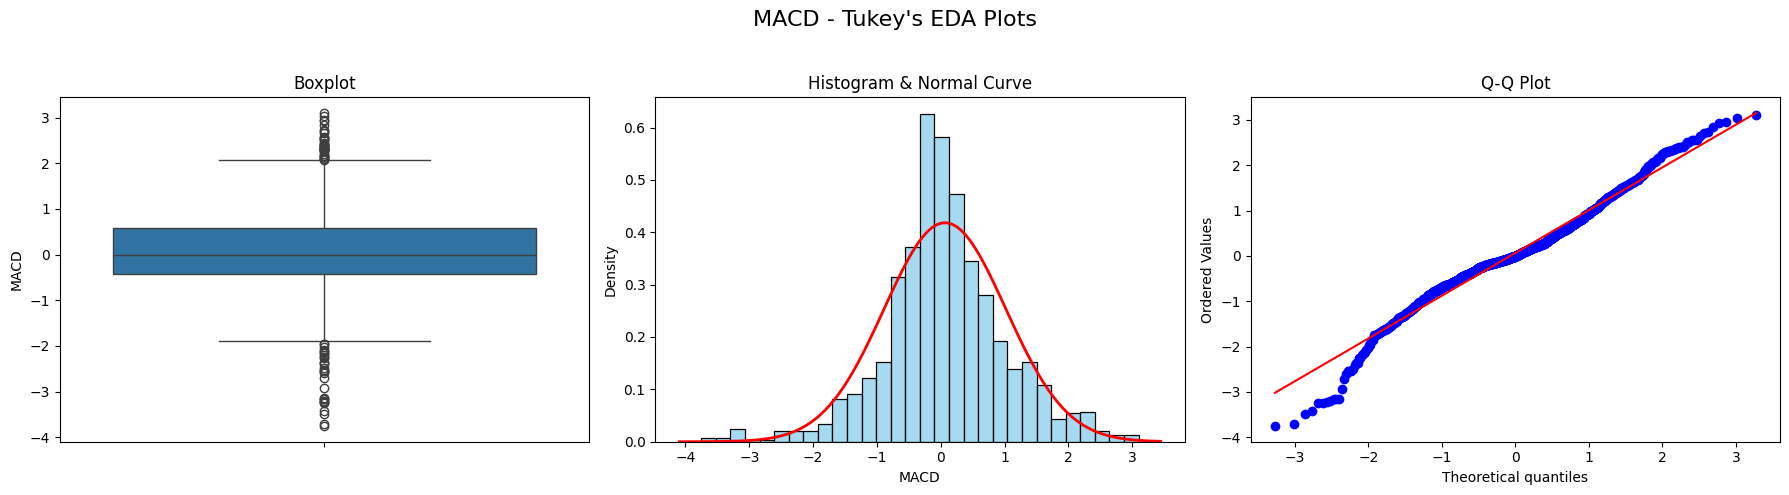

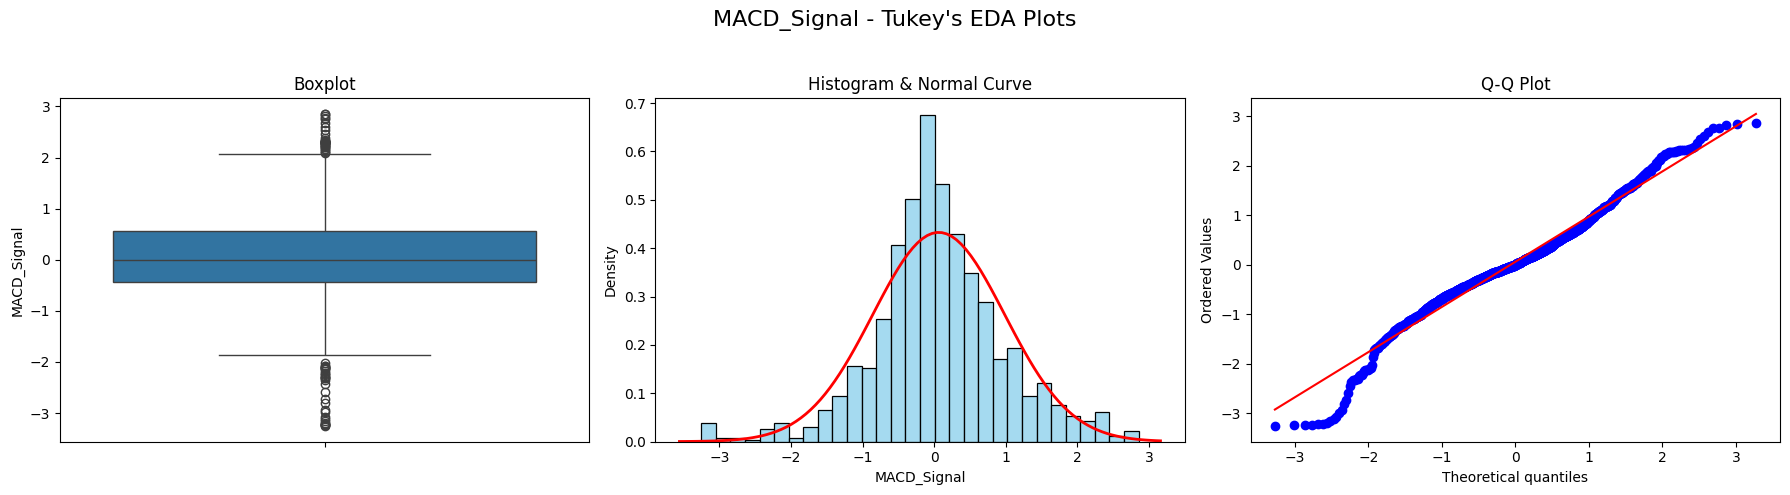

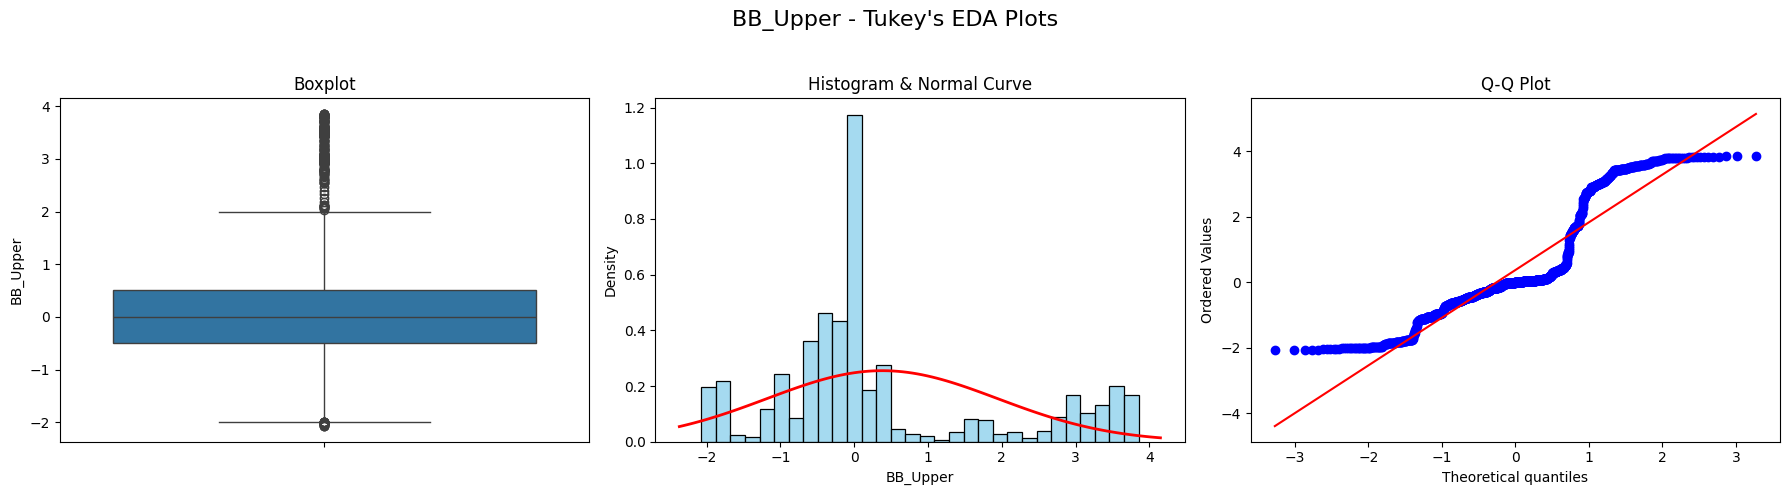

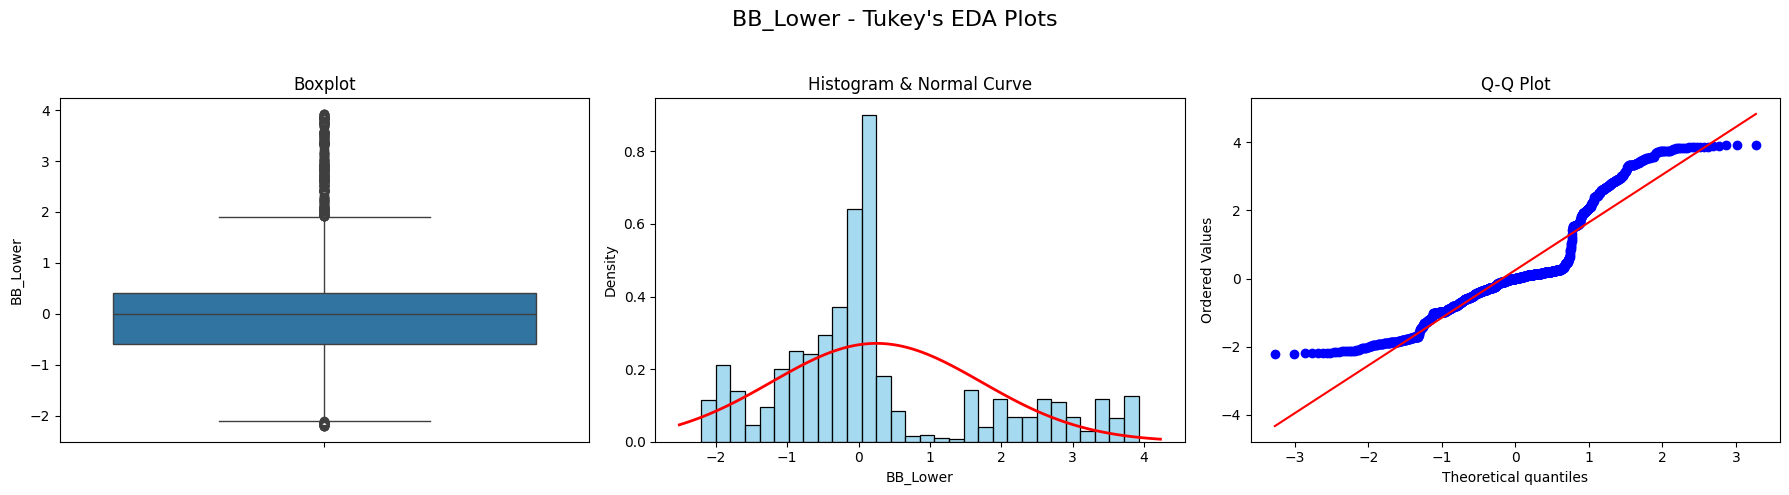

In [17]:
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import scipy.stats as stats

# 讀取標準化後的資料
df_robust = pd.read_csv("tsmc2330-2_Robust.csv")

# 需要繪圖的欄位
plot_cols = [col for col in df_robust.columns if col not in ["Column1", "Date", "Target"]]

for col in plot_cols:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"{col} - Tukey's EDA Plots", fontsize=16)
    
    # 盒鬚圖 (Boxplot)
    sns.boxplot(y=df_robust[col], ax=axes[0])
    axes[0].set_title("Boxplot")
    
    # 長條圖及常態分佈圖 (Histogram + Normal Curve)
    sns.histplot(df_robust[col], kde=False, stat="density", ax=axes[1], bins=30, color='skyblue')
    # 正態分佈曲線
    mu, std = df_robust[col].mean(), df_robust[col].std()
    xmin, xmax = axes[1].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    axes[1].plot(x, p, 'r', linewidth=2)
    axes[1].set_title("Histogram & Normal Curve")
    
    # Q-Q plot
    stats.probplot(df_robust[col], dist="norm", plot=axes[2])
    axes[2].set_title("Q-Q Plot")
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

### 特徵工程：加入技術指標 (MA5, MA10, MA20, BSI BB band.), 將漲、跌欄位改為 0(跌), 1(漲)，並放在最後一欄顯示

In [ ]:
#  選擇特徵與目標變數
features = df.drop(columns=["Column1", "Date", "Close", "Target"])  # 原tsmc2330-1.csv
features = df_robust.drop(columns=["Column1", "Date", "Close", "Target"])
X = features
y = df["Target"]



### 特徵選擇
#### 使用Pearson's correlation coefficient 計算

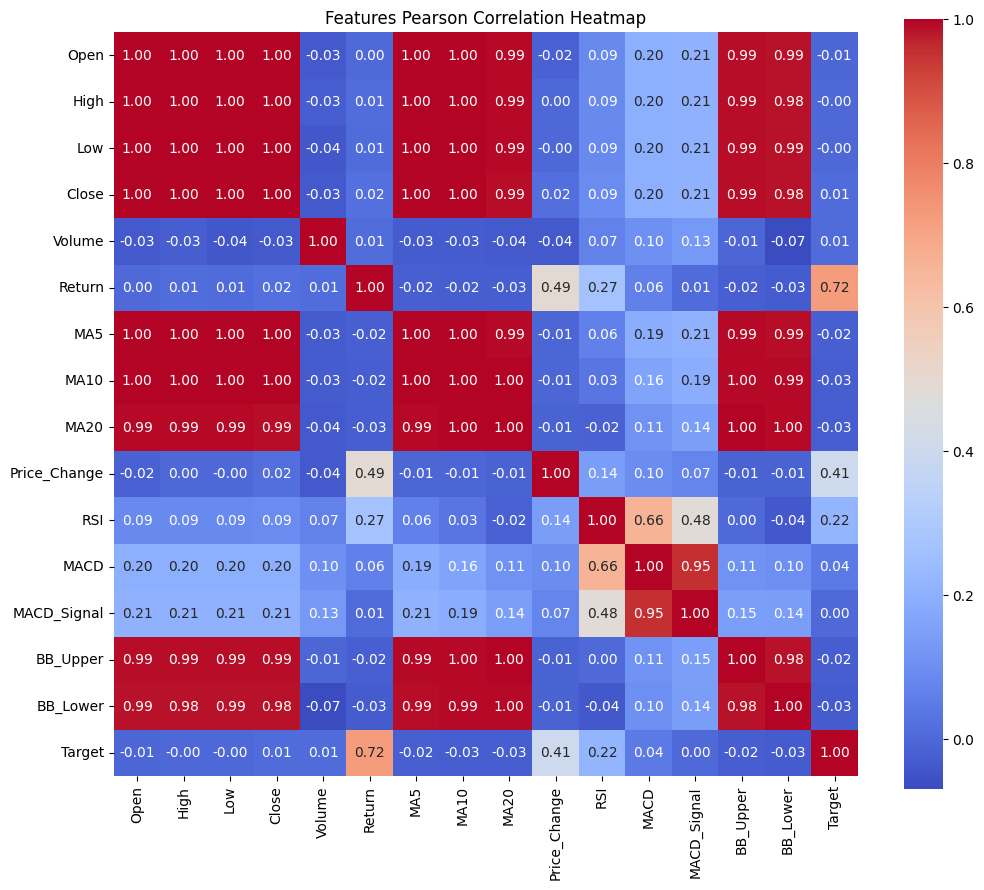

In [7]:
# 計算 Pearson's correlation coefficient
features2 =df.drop(columns=["Column1", "Date"])
corr_matrix = features2.corr(method='pearson')

# 繪製熱力圖
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Features Pearson Correlation Heatmap")
plt.show()

### 由熱力圖分析 Pearson's corelation coefficient, 最相關的特徵值如下:
Return: 0.72
Price change: 0.41
RSI: 0.22

### tsmc2330-2_Robust.csv 熱力圖

In [19]:
#  選擇特徵與目標變數
features_robust = df_robust.drop(columns=["Column1", "Date", "Close", "Target"])
X = features_robust
y = df_robust["Target"]

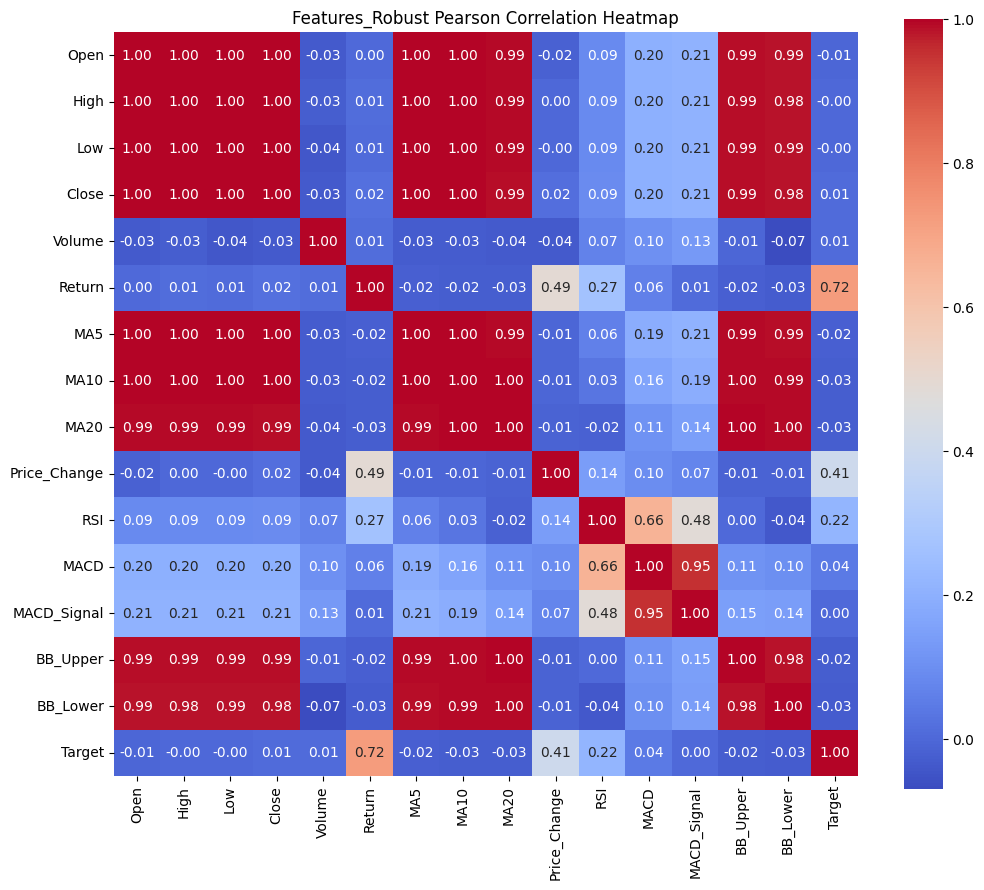

In [20]:
# 計算 Pearson's correlation coefficient
features2_robust =df_robust.drop(columns=["Column1", "Date"])
corr_matrix = features2_robust.corr(method='pearson')

# 繪製熱力圖
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Features_Robust Pearson Correlation Heatmap")
plt.show()

In [ ]:
# 📊 分割訓練與測試資料
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=False
)


In [25]:
#  回歸樹模型
tree_model = DecisionTreeClassifier(max_depth=5, random_state=0)
tree_model.fit(X_train, y_train)
tree_pred = tree_model.predict(X_test)

print("📘 回歸樹準確率：", accuracy_score(y_test, tree_pred))
print(classification_report(y_test, tree_pred))

📘 回歸樹準確率： 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       191
           1       1.00      1.00      1.00       197

    accuracy                           1.00       388
   macro avg       1.00      1.00      1.00       388
weighted avg       1.00      1.00      1.00       388



In [26]:
# 🌲 隨機森林模型
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("📗 隨機森林準確率：", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

📗 隨機森林準確率： 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       191
           1       1.00      1.00      1.00       197

    accuracy                           1.00       388
   macro avg       1.00      1.00      1.00       388
weighted avg       1.00      1.00      1.00       388



In [27]:
# 📈 邏輯迴歸模型
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

print("📙 邏輯迴歸準確率：", accuracy_score(y_test, lr_pred))
print(classification_report(y_test, lr_pred))

📙 邏輯迴歸準確率： 0.7860824742268041
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       191
           1       0.78      0.81      0.79       197

    accuracy                           0.79       388
   macro avg       0.79      0.79      0.79       388
weighted avg       0.79      0.79      0.79       388



In [28]:
# 💡 XGBoost 模型
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

print("📕 XGBoost 準確率：", accuracy_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))

d:\Github\Python-2025_04_25\MLOPS\mlops_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:56:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📕 XGBoost 準確率： 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       191
           1       1.00      1.00      1.00       197

    accuracy                           1.00       388
   macro avg       1.00      1.00      1.00       388
weighted avg       1.00      1.00      1.00       388



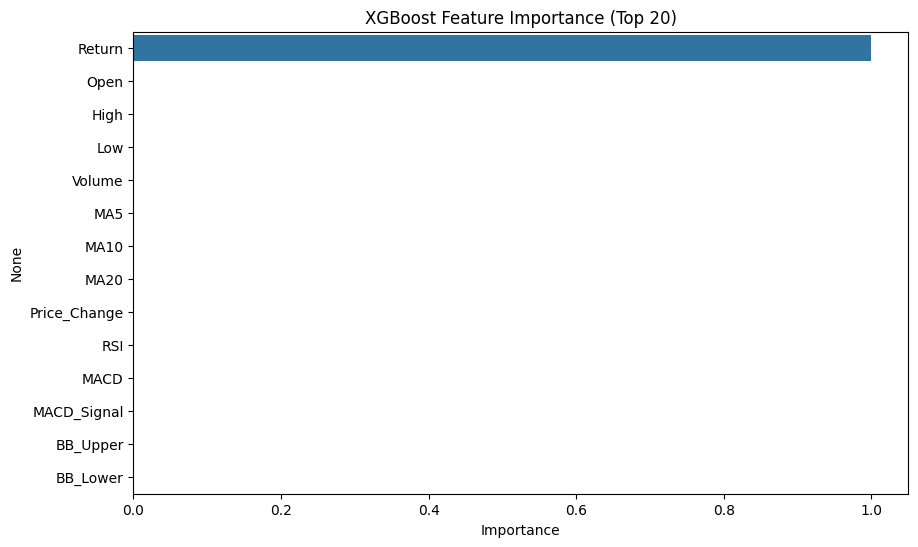

In [29]:
# 📊 特徵重要性分析 (以 XGBoost 為例)
xgb_importance = pd.Series(
    xgb_model.feature_importances_, index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=xgb_importance[:20], y=xgb_importance.index[:20])
plt.title("XGBoost Feature Importance (Top 20)")
plt.xlabel("Importance")
plt.show()

d:\Github\Python-2025_04_25\MLOPS\mlops_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:52:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


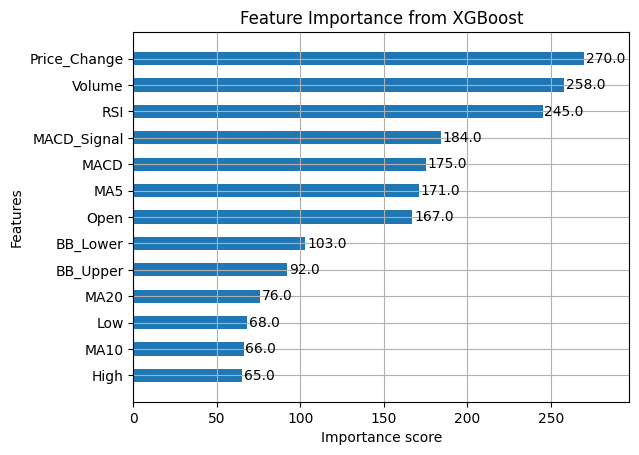

In [23]:
import xgboost as xgb
import matplotlib.pyplot as plt
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train)

# 顯示特徵重要性
xgb.plot_importance(xgb_model, max_num_features=15, height=0.5)
plt.title("Feature Importance from XGBoost")
plt.show()